In [1]:
import numpy as np
import multiprocessing
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from time import time
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

sns.set_style("darkgrid")
%matplotlib inline


Using TensorFlow backend.


## Считаем данные

In [3]:
data=np.array(pd.read_csv('data.csv'))
print(data[45])

['2004-01-04' 'capricorn'
 'Не будьте слишком настойчивы, побольше оригинальности в поступках. Дело, запланированное на сегодня, успешно завершится, а его плоды вы начнете собирать в скором будущем.']


## Разобьем каждое предложение на токены

In [4]:
def processText(data):
    tokens=[]
    for line in data:
        newToken=text_to_word_sequence(text=line[2],filters='!"#$%&amp;()*+,-./:;&lt;=>?@[\\]^_`{|}~\t\n\ufeff',
                                  lower=True,split=' ')
        tokens.append(newToken)
    return tokens

In [5]:
tokens=processText(data)
print(tokens[:2])

[['любые', 'разногласия', 'во', 'мнениях', 'скоро', 'улягутся', 'а', 'вы', 'продолжайте', 'делать', 'как', 'делали', 'но', 'постарайтесь', 'не', 'наступать', 'на', 'ноги', 'слишком', 'многим', 'иначе', 'ваши', 'сегодняшние', 'действия', 'сыграют', 'против', 'вас', 'в', 'будущем'], ['первый', 'день', 'нового', 'года', 'прекрасно', 'подходит', 'для', 'начинаний', 'которые', 'вы', 'постоянно', 'откладывали', 'в', 'прошлом', 'году', 'отбросьте', 'все', 'сомнения', 'и', 'действуйте', 'упор', 'может', 'быть', 'сделан', 'как', 'на', 'повышение', 'профессиональной', 'квалификации', 'так', 'и', 'на', 'реформацию', 'личной', 'жизни']]


###  Word2Vec

#### Создадим модель

In [6]:
cores = multiprocessing.cpu_count() 

w2v_model = Word2Vec(min_count=1,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-2)

#### Загрузим словарь 

In [7]:
t = time()

w2v_model.build_vocab(sentences=tokens, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.22 mins


#### Обучим модель на гороскопах и сохраним веса

In [34]:
#w2v_model.train(sentences=tokens, total_examples=w2v_model.corpus_count, epochs=400, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

#w2v_model.save("word2vec.model")

Time to train the model: 34.93 mins


#### Создадим новую модель на основе сохраненных весов

In [2]:
w2v_model = Word2Vec.load("weights/word2vec.model")

#### Посмотрим как выглядит вектор слова 

In [5]:
w2v_model['любые'][:10]

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 2.0657144 ,  2.1900077 , -3.5258808 ,  0.46440464, -1.2153951 ,
        0.25653356,  1.716226  , -1.5534272 , -2.1229277 , -2.86682   ],
      dtype=float32)

#### Посмотрим слова, близкие к заданному 

In [10]:
w2v_model.wv.most_similar(positive=["весы"])

[('девы', 0.7528153657913208),
 ('раки', 0.7447417974472046),
 ('водолеи', 0.7439862489700317),
 ('скорпионы', 0.7434227466583252),
 ('львы', 0.7415359020233154),
 ('тельцы', 0.7390024662017822),
 ('близнецы', 0.7383283376693726),
 ('рыбы', 0.7275119423866272),
 ('стрельцы', 0.7106574177742004),
 ('овны', 0.708452582359314)]

## Визуализация t-SNE

### Абсолютная визуализация

Выберем опорное слово и слова для сравнения. Изобразим их на диаграмме, где расстояне между точками отображает симантическую близость

In [3]:
def tsnescatterplot(model, word, list_names):
   
   # инициализируем массив слов для вывода 
    arrays = np.empty((0, 300), dtype='f')

    word_labels = [word]
    color_list  = ['red']
    
    # добавим вектор опорного слова в массив вывода
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # найдем наиболее похожие слова по отношению к опорному
    close_words = model.wv.most_similar([word])
    
    # добавим вектора похожих слов в массив вывода
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # добавим вектора интересующих слов в массив вывода
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # с помощью метода главных компонент уменьшим размероность массива вывода
    reduc = PCA(n_components=12).fit_transform(arrays)
    
    
    # сделаем вывод чисел с плав. зап. как вывод чисел с фикс. зап.
    np.set_printoptions(suppress=True)
    
    # получим умную 2-х мерную матрицу вывода из 12-ти мерной
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # создадим дф для вывода
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # проставляем точки
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # проставляем сами слова
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

### Выведем данные

Как это работает: Первое слово - опорное, все синие слова - самые близкие к опорному, массив других слов - слова для сравнения  с опорным

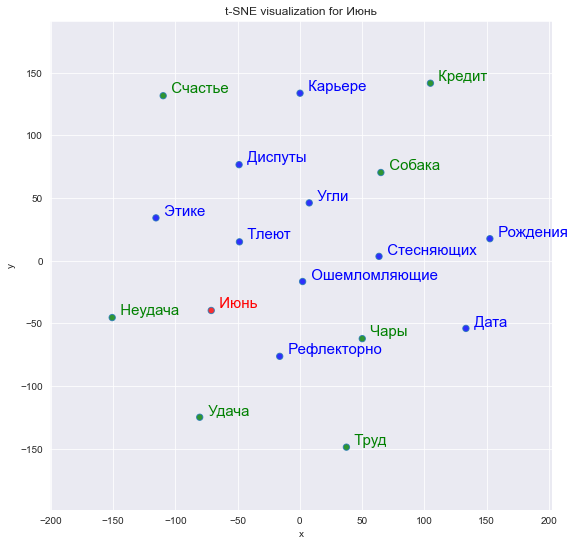

In [7]:
tsnescatterplot(w2v_model, 'июнь', ['чары','неудача','удача', 'собака','труд','кредит','счастье'])